In [1]:
%matplotlib inline

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import rec_parse

# Collect Data
To obtain data, a recipe is parsed to identify dictionary matches. Each dictionary entry corresponds to an index in recipe space. So, each recipe is represented as a vector in recipe space of dimension 4060. Beginnning with a set of 15768 recipe vectors. 10% of those vectors, at equal intervals are reserved as test data. The result should be 4 matrices, trainX representing 14191 recipe vectors, trainY representing binary labels for each of those recipes, testX representing 1577 recipe vectors on which to test, and testY reresenting labels for the test data. For the label matrices, a 1 in column 0 represents 'dinner', while a 1 in column 1 represents 'non-dinner'.

In [3]:
rec_parse.clear_data()

dinner_count = rec_parse.initialize_csv("rec_dinner_tag.csv")
breakfast_count = rec_parse.initialize_csv("breakfast_revision.csv")
dessert_count = rec_parse.initialize_csv("rec_dessert_tag.csv")

data = rec_parse.generate_training_data()

dinner_labels = np.zeros((dinner_count, 2), dtype=np.int)
breakfast_labels = np.zeros((breakfast_count, 2), dtype=np.int)
dessert_labels = np.zeros((dessert_count, 2), dtype=np.int)
                          
for label in dinner_labels:
    label[0] = 1
                          
for label in breakfast_labels:
    label[1] = 1
                          
for label in dessert_labels:
    label[1] = 1
    
labels = np.concatenate((dinner_labels, breakfast_labels), axis=0)
labels = np.concatenate((labels, dessert_labels), axis=0)

trainX, testX = rec_parse.split(data)
trainY, testY = rec_parse.split(labels)
                          
# # data = rec_parse.parse_recipes()
                          
# # trainX, testX = rec_parse.split(data)

# # trainY = np.zeros((len(data)-1577, 2), dtype=np.int)
# # testY = np.zeros([1577, 2], dtype=np.int)

# # for ind, row in enumerate(trainY):
# #     if ind > 1500:
# #         trainY[ind][1] = 1
# #     else:
# #         trainY[ind][0] = 1

# # for ind, row in enumerate(testY):
# #     if ind > 150:
# #         testY[ind][1] = 1
# #     else:
# #         testY[ind][0] = 1
        
print("Your data is ready.")
print("trainX shape =", trainX.shape)
print("trainY shape =", trainY.shape)
print("testX shape =", testX.shape)
print("testY shape =", testY.shape)

print(len(data))

Your data is ready.
trainX shape = (6998, 3530)
trainY shape = (6998, 2)
testX shape = (778, 3530)
testY shape = (778, 2)
7776


# Initialize graph features

At line 4, numEpochs is set very low at 100. This low number of epochs results in a model that builds quickly, but has low accuracy. to experiment with a more accurate model, increase numEpochs to at least 2000. To train a production model, you would likely run close to 30k, and probably continue running until cost no longer changes, or does so minimally from epoch to epoch.

In [4]:
numFeatures = trainX.shape[1]
numLabels = trainY.shape[1]

numEpochs = 27000

tf.reset_default_graph()

learningRate = tf.train.exponential_decay(learning_rate=0.0008,
                                          global_step= 1,
                                          decay_steps=trainX.shape[0],
                                          decay_rate= 0.95,
                                          staircase=True)

X = tf.placeholder(tf.float32, [None, numFeatures])
yGold = tf.placeholder(tf.float32, [None, numLabels])

# Initialize variables

In [5]:
weights = tf.Variable(tf.random_normal([numFeatures,numLabels],
                                       mean=0,
                                       stddev=(np.sqrt(6/numFeatures+
                                                         numLabels+1)),
                                       name="weights"))

bias = tf.Variable(tf.random_normal([1,numLabels],
                                    mean=0,
                                    stddev=(np.sqrt(6/numFeatures+numLabels+1)),
                                    name="bias"))

init_OP = tf.global_variables_initializer()

for i in tf.global_variables():
    print(i)  


Tensor("Variable/read:0", shape=(3530, 2), dtype=float32)
Tensor("Variable_1/read:0", shape=(1, 2), dtype=float32)


# The algorithm
Multiply trainX(14191, 4060) by weights(4060, 2), resulting in apply_weights_OP(14191, 2).
And add the bias(1, 2), resulting in add_bias_OP(14191, 2)

Activate using rectified linear:
f(x) = max(0, x)

Calculate loss using Mean Squared Error:
$\frac{1}{n}\sum_{i=0}^n ({y}_{estimated}-{y}_{real})^2$

Optimize using gradient descent.

In [6]:
# FEEDFORWARD ALGORITHM
apply_weights_OP = tf.matmul(X, weights, name="apply_weights")
add_bias_OP = tf.add(apply_weights_OP, bias, name="add_bias")
activation_OP = tf.nn.sigmoid(add_bias_OP, name="activation")

# COST FUNCTION i.e. MEAN SQUARED ERROR
cost_OP = tf.nn.l2_loss(activation_OP-yGold, name="squared_error_cost")

# OPTIMIZATION ALGORITHM i.e. GRADIENT DESCENT
training_OP = tf.train.GradientDescentOptimizer(learningRate).minimize(cost_OP)


#  Run training

step 0, training accuracy 0.469277
step 0, cost 3406.74
step 0, change in cost 3406.74
step 10, training accuracy 0.70663
step 10, cost 2162.26
step 10, change in cost 1244.48
step 20, training accuracy 0.735782
step 20, cost 1901.82
step 20, change in cost 260.434
step 30, training accuracy 0.747213
step 30, cost 1788.43
step 30, change in cost 113.392
step 40, training accuracy 0.754501
step 40, cost 1721.52
step 40, change in cost 66.915
step 50, training accuracy 0.757502
step 50, cost 1675.51
step 50, change in cost 46.006
step 60, training accuracy 0.760503
step 60, cost 1634.66
step 60, change in cost 40.8453
step 70, training accuracy 0.761503
step 70, cost 1602.42
step 70, change in cost 32.2412
step 80, training accuracy 0.763504
step 80, cost 1575.97
step 80, change in cost 26.4542
step 90, training accuracy 0.764647
step 90, cost 1553.1
step 90, change in cost 22.871
step 100, training accuracy 0.765504
step 100, cost 1533.6
step 100, change in cost 19.4995
step 110, traini

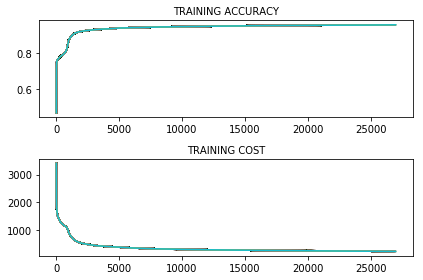

In [7]:
# Training epochs
with tf.Session() as sess:
    sess.run(init_OP)

    ###########################
    ### GRAPH LIVE UPDATING ###
    ###########################

    epoch_values=[]
    accuracy_values=[]
    cost_values=[]
    
    # Turn on interactive plotting
    plt.ion()
    # Create the main, super plot
    fig = plt.figure()
    # Create two subplots on their own axes and give titles
    ax1 = plt.subplot("211")
    ax1.set_title("TRAINING ACCURACY", fontsize=10)
    ax2 = plt.subplot("212")
    ax2.set_title("TRAINING COST", fontsize=10)
    plt.tight_layout()


    #####################
    ### RUN THE GRAPH ###
    #####################

    ## Ops for vizualization
    # argmax(activation_OP, 1) gives the label our model thought was most likely
    # argmax(yGold, 1) is the correct label
    correct_predictions_OP = tf.equal(tf.argmax(activation_OP,1),tf.argmax(yGold,1))
    # False is 0 and True is 1, what was our average?
    accuracy_OP = tf.reduce_mean(tf.cast(correct_predictions_OP, "float"))
    # Summary op for regression output
    activation_summary_OP = tf.summary.histogram("output", activation_OP)
    # Summary op for accuracy
    accuracy_summary_OP = tf.summary.scalar("accuracy", accuracy_OP)
    # Summary op for cost
    cost_summary_OP = tf.summary.scalar("cost", cost_OP)
    # Summary ops to check how variables (W, b) are updating after each iteration
    weightSummary = tf.summary.histogram("weights", weights.eval(session=sess))
    biasSummary = tf.summary.histogram("biases", bias.eval(session=sess))
    # Merge all summaries
    all_summary_OPS = tf.summary.merge_all()
    # Summary writer
    writer = tf.summary.FileWriter("summary_logs", sess.graph)

    # Initialize reporting variables
    cost = 0
    diff = 1

    for i in range(numEpochs): 
        if i > 1 and diff < .0001:
            print("change in cost %g; convergence."%diff)
            break
        else:
            # Run training step
            step = sess.run(training_OP, feed_dict={X: trainX, yGold: trainY})
            
            # Report occasional stats
            if i % 10 == 0:
                # Add epoch to epoch_values
                epoch_values.append(i)
                # Generate accuracy stats on test data
                summary_results, train_accuracy, newCost = sess.run(
                    [all_summary_OPS, accuracy_OP, cost_OP],
                    feed_dict={X: trainX, yGold: trainY}
                )
                # Add accuracy to live graphing variable
                accuracy_values.append(train_accuracy)
                # Add cost to live graphing variable
                cost_values.append(newCost)
                # Write summary stats to writer
                writer.add_summary(summary_results, i)
                # Re-assign values for variables
                diff = abs(newCost - cost)
                cost = newCost

                #generate print statements
                print("step %d, training accuracy %g"%(i, train_accuracy))
                print("step %d, cost %g"%(i, newCost))
                print("step %d, change in cost %g"%(i, diff))

                # Plot progress to our two subplots
                accuracyLine, = ax1.plot(epoch_values, accuracy_values)
                costLine, = ax2.plot(epoch_values, cost_values)
                fig.canvas.draw()
                time.sleep(1)
    
    # Create Saver
    saver = tf.train.Saver()   
    saver.save(sess, '/tmp/dinner-model')

    # How well do we perform on held-out test data?
    print("final accuracy on test set: %s" %str(sess.run(accuracy_OP,
                                                         feed_dict={X: testX,
                                                                    yGold: testY})))

# Import new set
Now we'll bring in the 1000 most recent recipes published to Cookpad and return those which are identified by the algorithm as 'dinner' so that we can subject them to human analysis. 

In [8]:
data = rec_parse.parse_newest_recipes() 
print("data shape =", data.shape)

data shape = (1000, 3530)


In [11]:
import csv
with tf.Session() as lolo:
    saver.restore(lolo, '/tmp/dinner-model')
    print("Model restored.")
    print("Checking ", len(data), "recipes.")
    
    predictions = lolo.run(activation_OP, feed_dict={X: data})

    
    id_set = []
    
    for index, i in enumerate(predictions):
        if i[0] > .9:
            id_set.append(index)
    
    for n in rec_parse.convert_to_id(id_set):  
        print('cookpad.com/us/recipes/' + n[1])
        
    print(len(id_set), "dinner recipes detected")
    


Model restored.
Checking  1000 recipes.
cookpad.com/us/recipes/1901363
cookpad.com/us/recipes/1901174
cookpad.com/us/recipes/1901046
cookpad.com/us/recipes/1852212
cookpad.com/us/recipes/1887106
cookpad.com/us/recipes/1900885
cookpad.com/us/recipes/1900769
cookpad.com/us/recipes/1894815
cookpad.com/us/recipes/1900260
cookpad.com/us/recipes/1900061
cookpad.com/us/recipes/1900033
cookpad.com/us/recipes/1886048
cookpad.com/us/recipes/1899166
cookpad.com/us/recipes/1899223
cookpad.com/us/recipes/1896589
cookpad.com/us/recipes/1892434
cookpad.com/us/recipes/1767101
cookpad.com/us/recipes/1893362
cookpad.com/us/recipes/1897481
cookpad.com/us/recipes/1891957
cookpad.com/us/recipes/1892432
cookpad.com/us/recipes/1896877
cookpad.com/us/recipes/1896742
cookpad.com/us/recipes/1896649
cookpad.com/us/recipes/1896645
cookpad.com/us/recipes/1896641
cookpad.com/us/recipes/1896181
cookpad.com/us/recipes/1896221
cookpad.com/us/recipes/1896131
cookpad.com/us/recipes/1891267
cookpad.com/us/recipes/1866839